In [1]:
import sys
import os
sys.stdout = open(os.devnull, "w")
print("Hiii")
sys.stdout = sys.__stdout__
print("Hello")

Hello
hey


In [2]:
print("hey")

In [3]:
import os
import math
from typing import List, Dict

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import CLIPModel, CLIPProcessor
from torch.nn.functional import cosine_similarity

2025-11-26 19:03:09.109969: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
class LoRALinear(nn.Module):
    
    def __init__(self, base_layer: nn.Linear, r: int = 8, alpha: float = 16.0):
        super().__init__()
        self.in_features = base_layer.in_features
        self.out_features = base_layer.out_features
        self.r = r
        self.alpha = alpha
        self.scaling = alpha / r

        # Original (frozen) weight & bias
        self.base = base_layer

        # LoRA trainable weights
        self.lora_A = nn.Linear(self.in_features, r, bias=False)
        self.lora_B = nn.Linear(r, self.out_features, bias=False)

        # Init LoRA
        nn.init.kaiming_uniform_(self.lora_A.weight, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B.weight)

    def forward(self, x):
        return (
            self.base(x) + self.scaling*self.lora_B(self.lora_A(x))
        )

In [5]:
def apply_lora_to_clip_attn(model: nn.Module, r: int = 8, alpha: float = 16.0):
    """
    Replace all q_proj and v_proj Linear layers in CLIP with LoRALinear.
    """
    for module_name, module in model.named_modules():
        for child_name, child in list(module.named_children()):
            if isinstance(child, nn.Linear) and child_name in ["q_proj", "v_proj"]:
                lora_layer = LoRALinear(child, r=r, alpha=alpha)
                setattr(module, child_name, lora_layer)

In [6]:
import torch

def load_lora_weights(model, path):
    lora_state = torch.load(path, map_location="cpu")

    for name, module in model.named_modules():
        if isinstance(module, LoRALinear) and name in lora_state:
            module.lora_A.load_state_dict(lora_state[name]["lora_A"])
            module.lora_B.load_state_dict(lora_state[name]["lora_B"])

    print("Loaded LoRA weights from", path)


In [7]:
from transformers import CLIPModel, CLIPProcessor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", cache_dir = "./clip_cache")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", cache_dir = "./clip_cache")
apply_lora_to_clip_attn(model, r=8, alpha=16)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [8]:
lora_state = torch.load("lora_weight_1_0.5_0.5.pt", map_location="cpu")

In [9]:
for name, module in model.named_modules():
    if isinstance(module, LoRALinear) and name in lora_state:
        module.lora_A.load_state_dict(lora_state[name]["lora_A"])
        module.lora_B.load_state_dict(lora_state[name]["lora_B"])

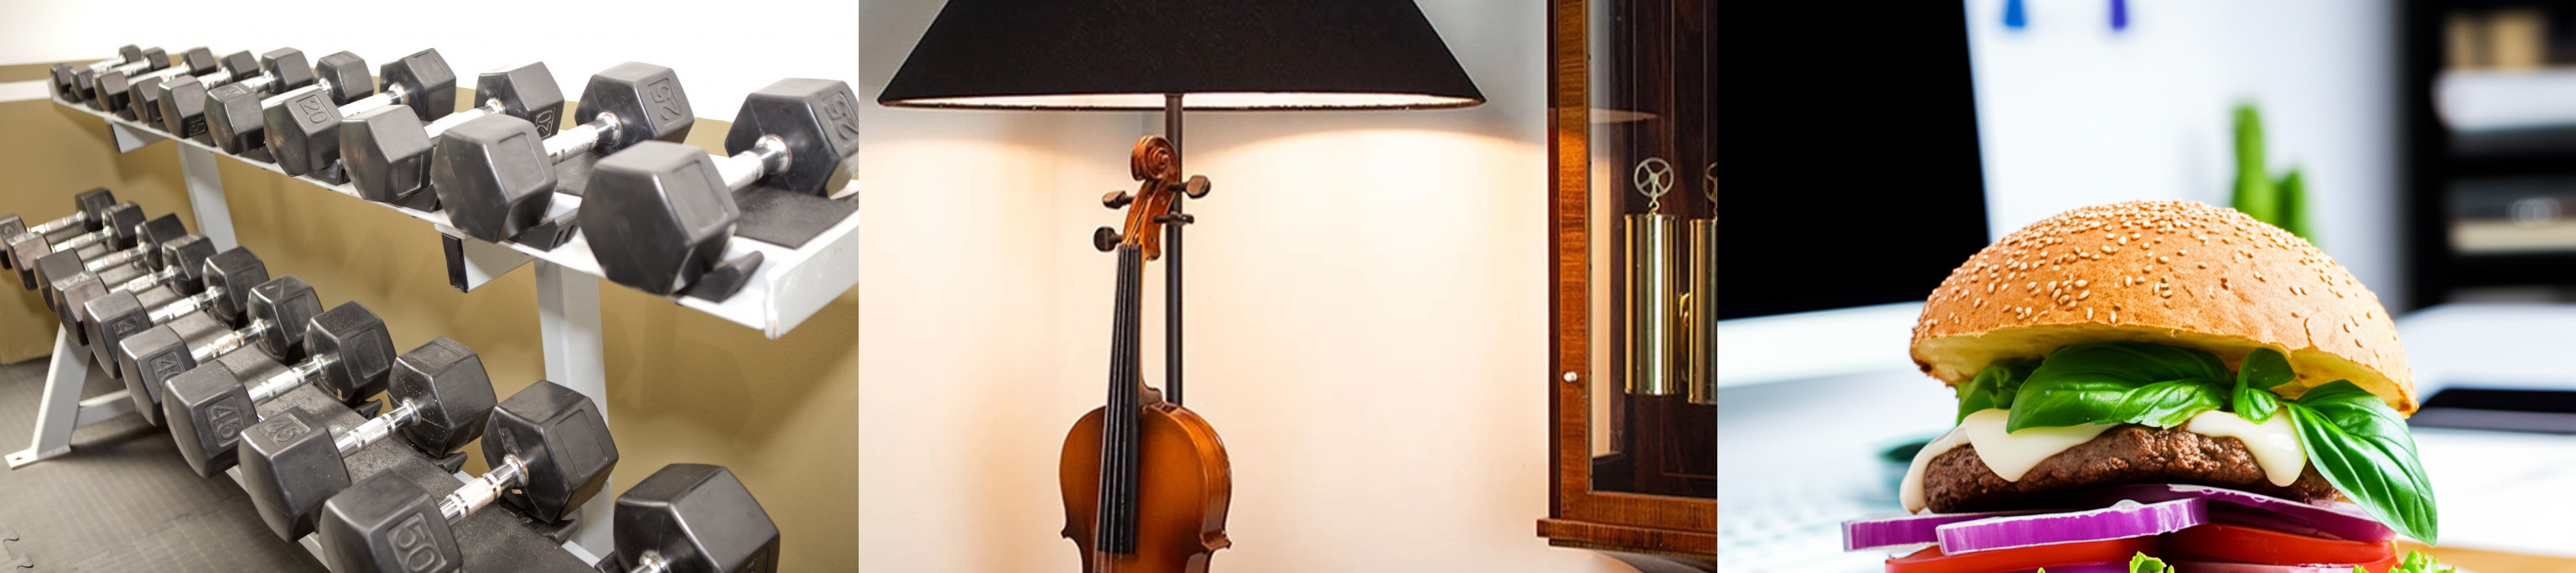

In [46]:
from PIL import Image
import requests

def image_grid(imgs, cols):
    rows = (len(imgs) + cols - 1) // cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

cola_image = Image.open("Data/others/1 (9).png")
cycle_image = Image.open("Data/others/1 (8).png")
combo3_image = Image.open("Data/burgers/1 (15).png")

images = [cola_image, cycle_image, combo3_image]

# for url in image_urls:
#     images.append(Image.open(requests.get(url, stream=True).raw))


grid = image_grid(images, cols=3)
display(grid)

In [51]:
classes = ['A tasty hamburger',  'A guy riding a cycle','A kid in the park', 'A coldplay concert']
inputs = processor(text=classes, images=images, return_tensors="pt", padding=True, do_convert_rgb=False)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
# probs = logits_per_image
l = probs.tolist()



In [52]:
l

[[0.24847052991390228,
  0.2320014387369156,
  0.2449302226305008,
  0.27459779381752014],
 [0.2502847909927368,
  0.2312302440404892,
  0.24498362839221954,
  0.27350130677223206],
 [0.24738110601902008,
  0.23390856385231018,
  0.24432188272476196,
  0.27438846230506897]]

/tmp/ipykernel_3946750/57237799.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels, rotation=20, ha='right')
/tmp/ipykernel_3946750/57237799.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels, rotation=20, ha='right')
/tmp/ipykernel_3946750/57237799.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels, rotation=20, ha='right')


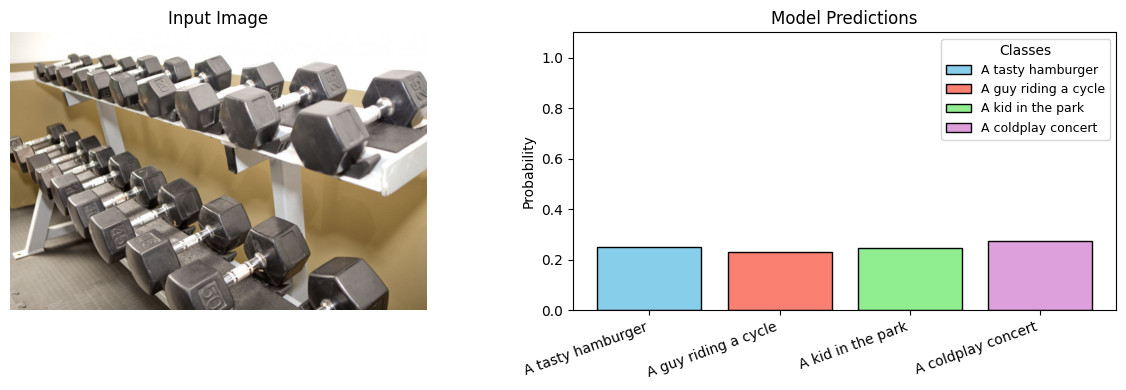

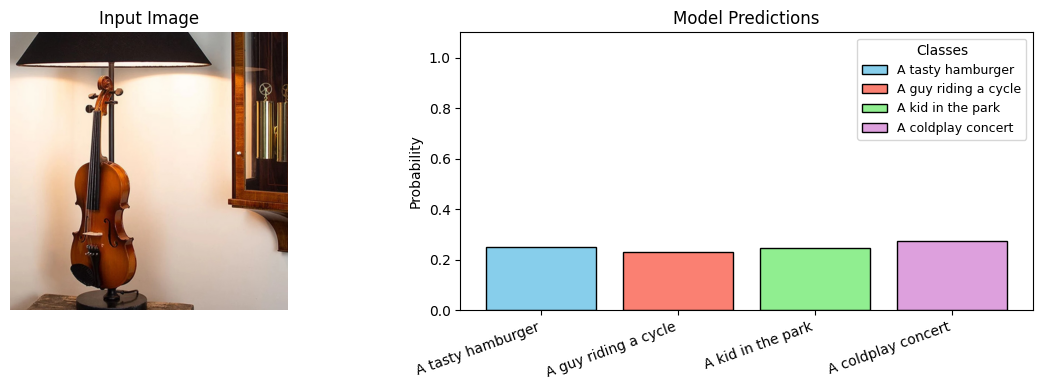

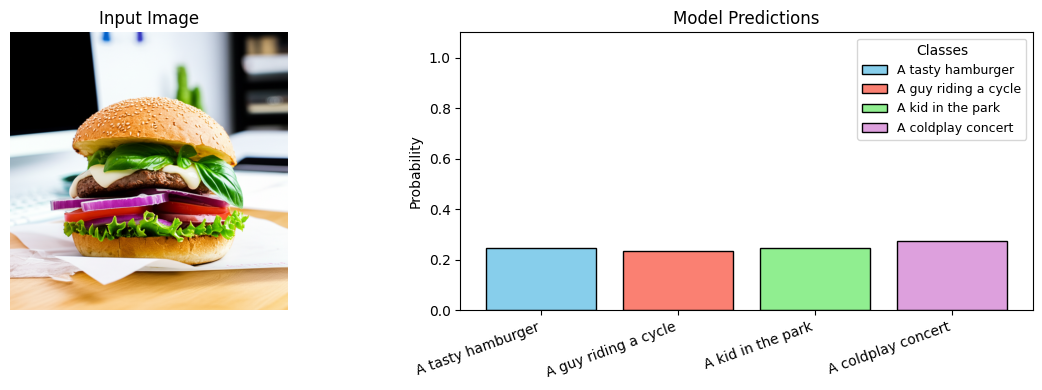

In [53]:
import matplotlib.pyplot as plt
import numpy as np

labels = classes   # your class names

for i, imss in enumerate(images):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # ------------------
    # IMAGE
    # ------------------
    axes[0].imshow(imss)
    axes[0].axis("off")
    axes[0].set_title("Input Image")
    colors = ["skyblue", "salmon", "lightgreen", "plum"]
    # ------------------
    # BAR CHART
    # ------------------
    bars = axes[1].bar(labels, l[i], color=colors, edgecolor='black')

    axes[1].set_xticklabels(labels, rotation=20, ha='right')
    axes[1].set_ylabel("Probability")
    axes[1].set_ylim(0, 1.1)
    axes[1].set_title("Model Predictions")

    # Add legend mapping color \u2192 class names
    axes[1].legend(bars, labels, title="Classes", fontsize=9, loc="upper right")

    plt.tight_layout()

plt.show()


In [42]:
from transformers import CLIPProcessor, CLIPModel

model2 = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", cache_dir = "./clip_cache")
processor2 = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", cache_dir = "./clip_cache")

In [43]:
# classes = ['a kid', 'a burger', 'a kid eating a burger', 'adventure trip on the road']
inputs = processor2(text=classes, images=images, return_tensors="pt", padding=True, do_convert_rgb=False)

outputs = model2(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
# probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
probs = logits_per_image
l2 = probs.tolist()

/tmp/ipykernel_3946750/3580836816.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels, rotation=20, ha='right')
/tmp/ipykernel_3946750/3580836816.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels, rotation=20, ha='right')
/tmp/ipykernel_3946750/3580836816.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels, rotation=20, ha='right')


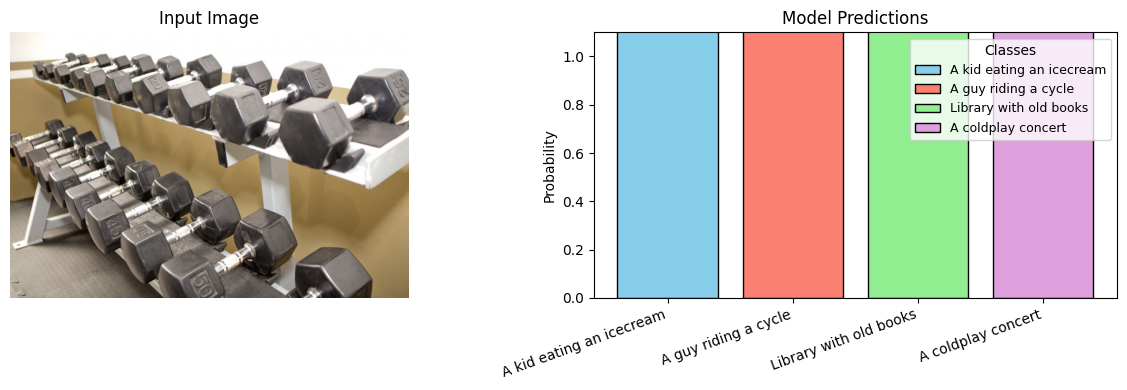

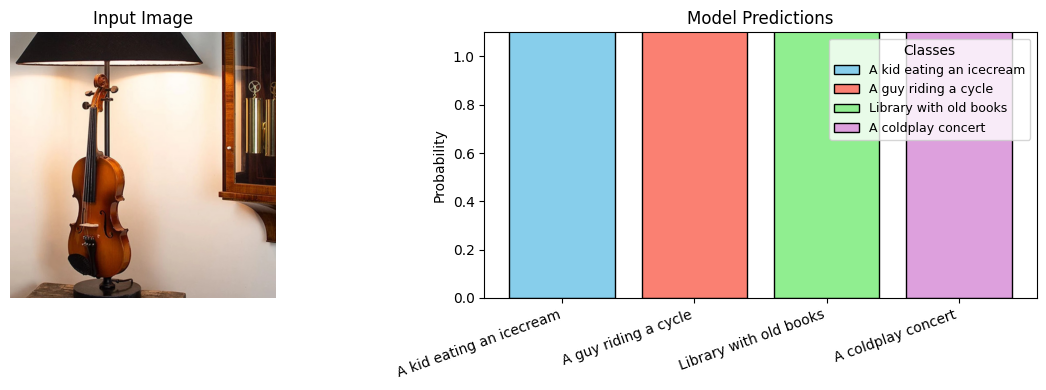

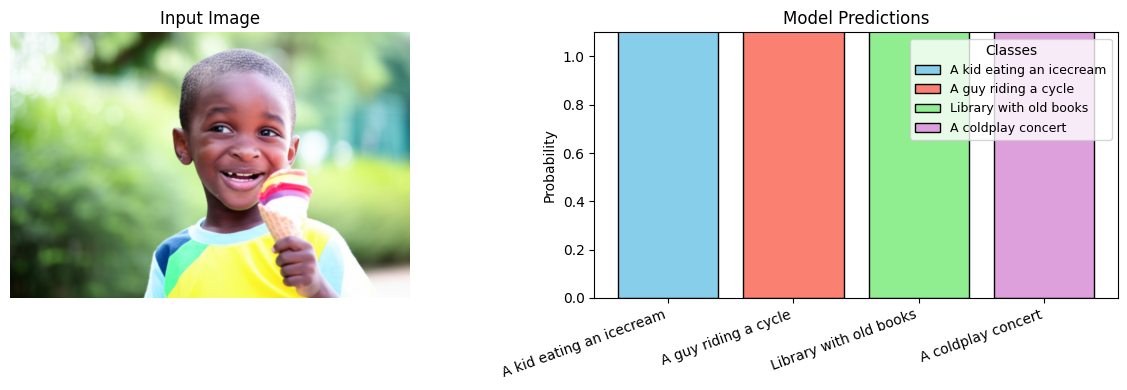

In [44]:
import matplotlib.pyplot as plt
import numpy as np

labels = classes   # your class names

for i, imss in enumerate(images):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # ------------------
    # IMAGE
    # ------------------
    axes[0].imshow(imss)
    axes[0].axis("off")
    axes[0].set_title("Input Image")
    colors = ["skyblue", "salmon", "lightgreen", "plum"]
    # ------------------
    # BAR CHART
    # ------------------
    bars = axes[1].bar(labels, l2[i], color=colors, edgecolor='black')

    axes[1].set_xticklabels(labels, rotation=20, ha='right')
    axes[1].set_ylabel("Probability")
    axes[1].set_ylim(0, 1.1)
    axes[1].set_title("Model Predictions")

    # Add legend mapping color \u2192 class names
    axes[1].legend(bars, labels, title="Classes", fontsize=9, loc="upper right")

    plt.tight_layout()

plt.show()


In [45]:
l2

[[11.813911437988281,
  17.0461483001709,
  16.146636962890625,
  15.479191780090332],
 [11.701006889343262,
  13.604181289672852,
  18.821672439575195,
  18.55411720275879],
 [28.849714279174805,
  17.861461639404297,
  13.673820495605469,
  17.694211959838867]]